In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm


from tqdm import tqdm

In [2]:
healthy = sc.read_h5ad("GSE174188/GSE174188_CLUES1_adjusted.h5ad")
healthy = healthy[healthy.obs.Status == "Healthy", :]
healthy

View of AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [3]:
cell_type = list(set(healthy.obs.cg_cov))
cell_type

['B', 'T4', 'pDC', 'PB', 'NK', 'T8', 'ncM', 'cDC', 'cM', 'Prolif', 'Progen']

C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\ProgramData\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


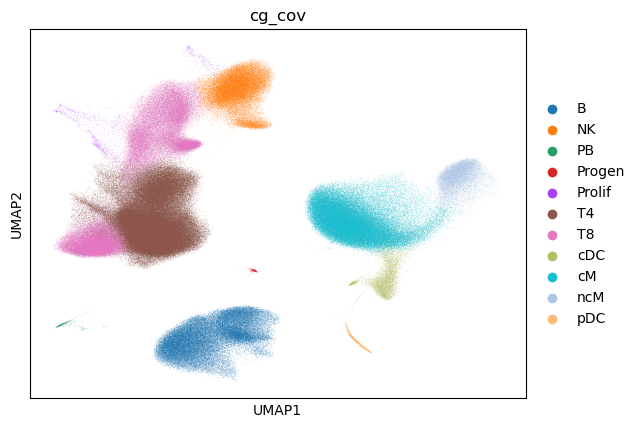

In [4]:
sc.pl.umap(healthy, color = "cg_cov")

# 開始處理cell dispersion

我需要先把每個人的部分個別提取出來，最後再將每個人的NK提取出來做cell dispersion

In [5]:
sample = list(set(healthy.obs.ind_cov))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = healthy[healthy.obs.ind_cov == i, :]
len(personal)

99

In [6]:
personal["HC-572"]

View of AnnData object with n_obs × n_vars = 5248 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cg_cov_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))
# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

# Cell Dispersion Calculate

In [8]:
# 將30~50個不同的cell放入新的dataframe中，以便後續進行計算
def renew_sampling_list(cell_type, minimum):
    # 隨機抽樣，抽取30~50個不同的cell之後要做cell dispersion的計算
    sampling = []
    for i in range(0, int(min(1/2*minimum,50))):
        # 挑出cell的位置
        cell = random.randrange(0, cell_type.n_obs)
        while cell in sampling:
            cell = random.randrange(0, cell_type.n_obs)
        sampling.append(cell)
    
    # 紀錄30~50個cell * gene的資料
    cell_dispersion = []
    # 先將 cell type 變成dataframe後，做 transpose 之後才能夠把挑選出來的 genes 放進去
    cell_type_transpose = pd.DataFrame(data = cell_type.X, columns = cell_type.var.index.values)
    # 做50次的隨機抽樣並且將結果
    for i in range(0, int(min(1/2*minimum, 50))):
        # 將dataframe塞進去新的list中
        cell_dispersion.append(cell_type_transpose.loc[sampling[i]])
    #將list轉成dataframe的格式
    cell_dispersion = np.array(cell_dispersion)
    
    return cell_dispersion

# 將某一個人的 cell type 提取出來做cell dispersion, 之後再拿其他人的去做比較 
# 要給numpy array的格式
def create_distance_matrix(data):
    # must be two dimension array, so need to change dataframe into array
    ncells = data.shape[0]
    
    # matric 會是aaabbbccc
    index1 = np.concatenate(tuple(np.repeat(i, ncells) for i in range(0,ncells)), axis =None)
    # matirc 會是abcabcabc
    index2 = np.tile(np.arange(0, ncells, 1), ncells)
    
    X = data[:, index1]
    Y = data[:, index2]
    
    # Euclidean Distance 
    out = np.sqrt(np.sum((X - Y) * (X - Y), axis = 0))
    
    distance_matrix = np.reshape(out, (ncells, ncells))
    
    return distance_matrix

# 計算離散程度，將n*n計算過後的matrix丟進來
def calculate_dispersion(distance):
    # np.triu只取上三角，其餘的都變成0
    dispersion = np.triu(distance).sum()/np.count_nonzero(np.triu(distance))
    return dispersion


# 將上面的所有的function合併成這個function執行
def Excute_all(sorted_personal, cell_type_name):# cell_type_name是字串的型態
    
    # 挑出最小值
    minimum = 50
    for i in sorted_personal:
        a = sorted_personal[i][sorted_personal[i].obs.cg_cov == cell_type_name, :].obs
        if len(a) < minimum:
            minimum = len(a)

    pbar = tqdm(total = len(sorted_personal))

    dispersion_personal = []
    mean = []
    distance = []
    # 總共人數
    for i in sorted_personal:
        dispersion = []
        # 取得所需的cell type
        celltype = sorted_personal[i][sorted_personal[i].obs.cg_cov == cell_type_name, :]
        # 1000 times sampling
        for j in range(0,1000):
            # 取得sampling的dataframe
            cell_dispersion = renew_sampling_list(celltype, minimum)
            # 計算 cell * cell distance
            distance_matrix = create_distance_matrix(cell_dispersion)
            # 取得此次抽樣的dispersion
            dispersion.append(calculate_dispersion(distance_matrix))
        
       
        distance.append(distance_matrix)
        
        dispersion_personal.append(dispersion)
        mean.append(np.mean(dispersion))
        
        pbar.update()
    
    pbar.close()
    
    # 計算標準差
    count = 0
    std = [] # 每一個人的標準差
    for i in range(len(distance)):
        count = (distance[i]-mean[i]) * (distance[i]-mean[i])
        std.append(np.sqrt(np.sum(count)/(len(distance)*((len(distance[i])*(len(distance[i])-1))/2)-1)))
    
    
    return dispersion_personal, mean, std

# 結果畫圖

In [9]:
def scatter_plot(data, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = data[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.scatter(x, y, color = cmap(i))

    # 給圖表加上標題和軸標籤
    plt.title(title)
    
    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)  
    
    plt.xlabel('Age')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(age, fontsize = 6, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188//Scatter_plot_{cell_type}.png', dpi=900)

    
    
    # 顯示圖表
    plt.show()
    

def errorbar(mean, std, title, cell_type):
    # 獲取所有的顏色名稱
    #all_colors = list(mcolors.CSS4_COLORS.keys())

    # 隨機選擇11種顏色
    #colors = np.random.choice(all_colors, size=11)
    cmap = plt.get_cmap('nipy_spectral', len(personal))

    for i in range(len(personal)):
        # 假設 x 軸是數據的索引，y 軸是數據的值
        x = int(float(age[i]))
        y = mean[i]

         # 使用 plt.scatter 方法來創建散點圖
        plt.errorbar(x, y, yerr = std[i], color = cmap(i), fmt = 'o')

    # 這將 x 軸的刻度標籤大小設置為 8
    plt.tick_params(axis='x', labelsize=8)  
    # 這將 x 軸的刻度標籤旋轉 60 度
    plt.xticks(rotation = 60)
        
    # 計算趨勢線的參數
    z = np.polyfit([int(float(a)) for a in age], mean, 1)
    # 創建一個多項式函數
    p = np.poly1d(z)
    print("斜率 :",p)
    test = list(set([int(float(a)) for a in age]))
    # 在圖中添加趨勢線
    plt.plot(test, p(test), 'r--', label='Trend Line')
    
    
    # 給圖表加上標題和軸標籤
    plt.title(title)
    plt.xlabel('Age')
    plt.ylabel('Value')

    # 添加圖例
    plt.legend(["Trand Line"] + age, fontsize = 6, bbox_to_anchor=(1.05, 1), loc='upper left', ncol = 4)
    
    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/errorbar_{cell_type}.png', dpi=900)

    # 顯示圖表
    plt.show()
    
def distribution(mean, std, age, cell_type):
    for i in range(0, len(mean)):
        x = np.arange(-4, 10, 0.001)
        y = norm.pdf(x, mean[i], std[i])
        plt.plot(x,y)
    
    # 添加圖例
    plt.legend(age, fontsize = 8, bbox_to_anchor = (1.05, 1), loc = 'upper left', ncol = 4)
    # 添加標題和軸標籤
    plt.title(f"{cell_type} cell dispersion")
    plt.xlabel('Different Sample')
    plt.ylabel('Probability Density')


    # 將圖形保存為PNG文件
    plt.savefig(f'Result_picture/GSE174188/{cell_type} cell dispersion.png', dpi=900)

# 確認細胞數量

In [10]:
# 確認細胞數量
a = []
for i in sorted_personal:
    a.append(sorted_personal[i][sorted_personal[i].obs.cg_cov == "ncM",:])   
for i in range(len(a)):
    #print(a[i].n_obs)
    0

# 測試用~ncM(non-classical monocytes)有一個人只有一顆cell，PB(Plasmablast)過少,Progen(CD34+ progenitor)過少，pDC(plamacytoid DC)過少
# Prolif(Proliferating lymphocytes)過少,cDC(conventional DC)有一個人只有一顆cell

# 只有T4, T8, NK, cM, B是夠的

# NK cell dispersion

In [11]:
dispersion_personal_NK, mean_NK, std_NK = Excute_all(sorted_personal, "NK")

100%|██████████| 99/99 [01:32<00:00,  1.07it/s]


In [12]:
'''count = 0
for i in sorted_personal:
    print(i)
    print("Age : ", age[count])
    print("Mean : ",mean_NK[count])
    print("Standard Deviation : ", std_NK[count], "\n")
    
    count += 1 '''

'count = 0\nfor i in sorted_personal:\n    print(i)\n    print("Age : ", age[count])\n    print("Mean : ",mean_NK[count])\n    print("Standard Deviation : ", std_NK[count], "\n")\n    \n    count += 1 '

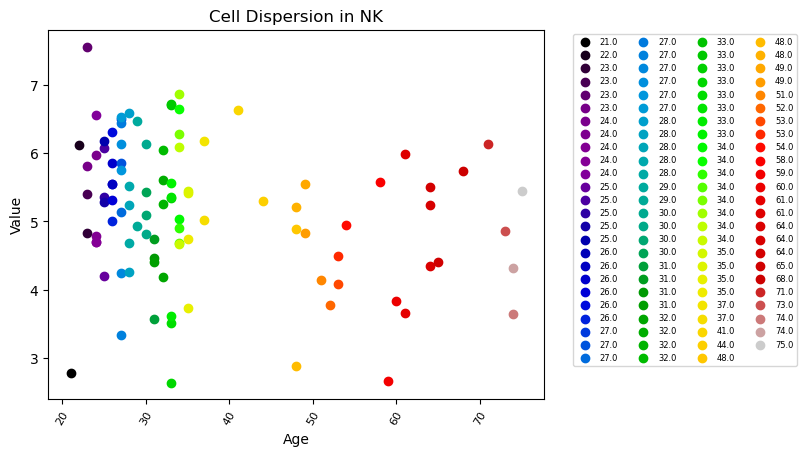

In [13]:
scatter_plot(mean_NK, "Cell Dispersion in NK", "NK")

斜率 :  
-0.01727 x + 5.8


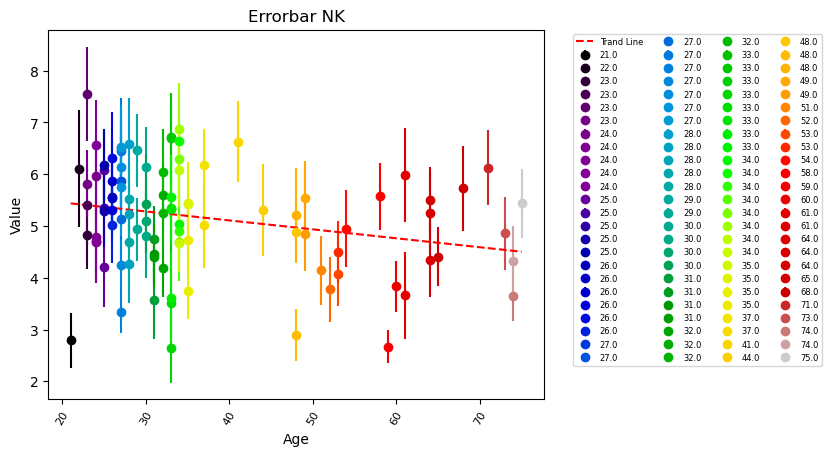

In [14]:
errorbar(mean_NK, std_NK, "Errorbar NK", "NK")

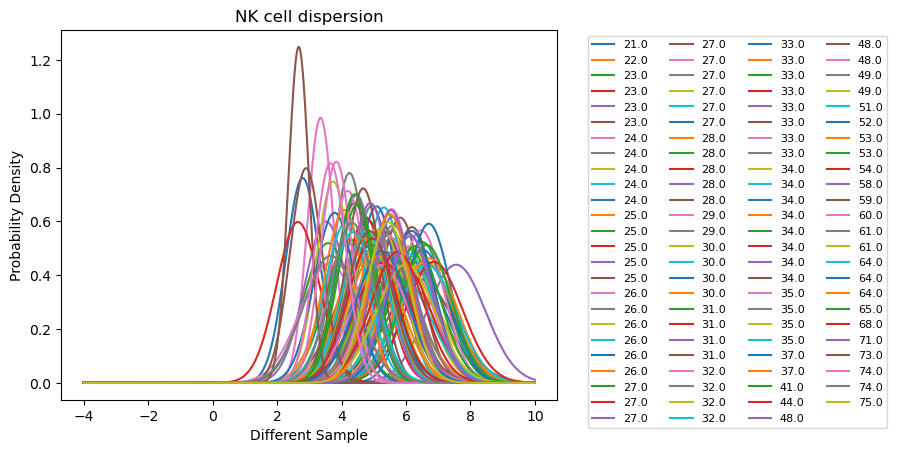

In [15]:
distribution(mean_NK, std_NK, age, "NK")

# cM(classical Monocyte) cell dispersion

In [16]:
dispersion_personal_cM, mean_cM, std_cM = Excute_all(sorted_personal, "cM")

100%|██████████| 99/99 [02:56<00:00,  1.78s/it]


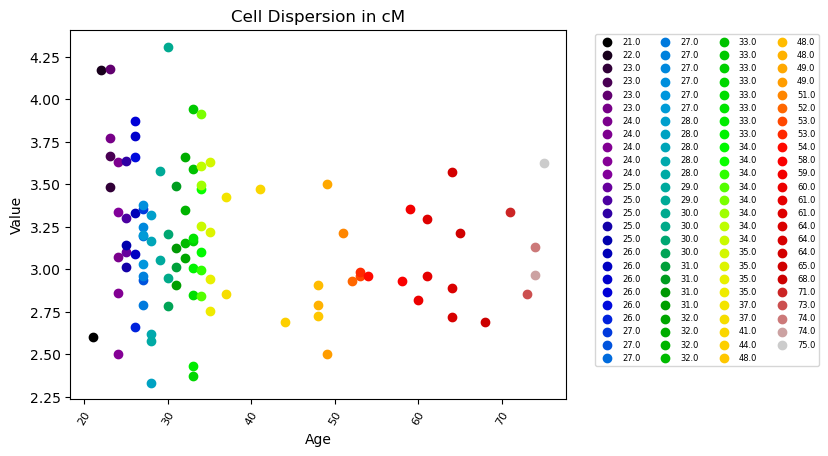

In [17]:
scatter_plot(mean_cM, "Cell Dispersion in cM", "cM")

斜率 :  
-0.004968 x + 3.354


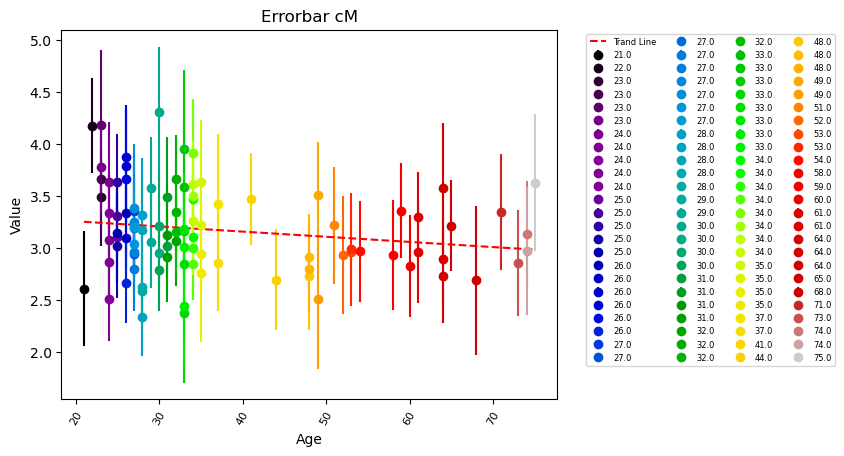

In [18]:
errorbar(mean_cM, std_cM, "Errorbar cM", "cM")

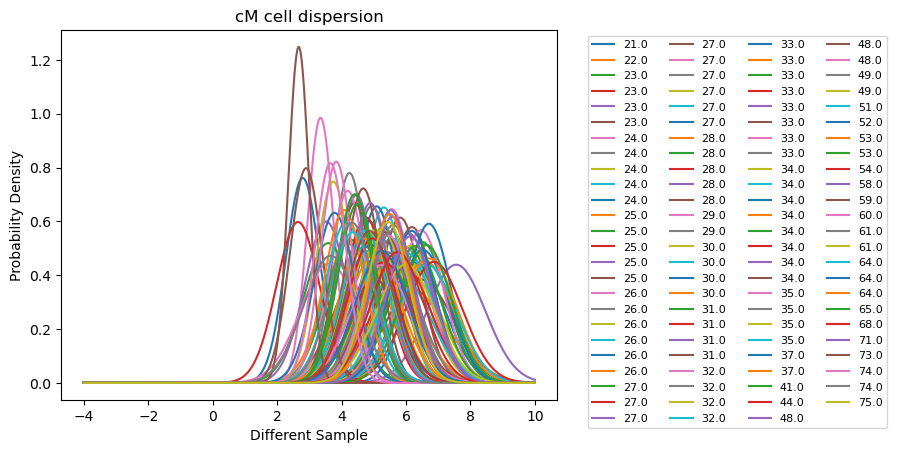

In [19]:
distribution(mean_NK, std_NK, age, "cM")

# T4 cell dispersion

In [20]:
dispersion_personal_T4, mean_T4, std_T4 = Excute_all(sorted_personal, "T4")

100%|██████████| 99/99 [05:56<00:00,  3.60s/it]


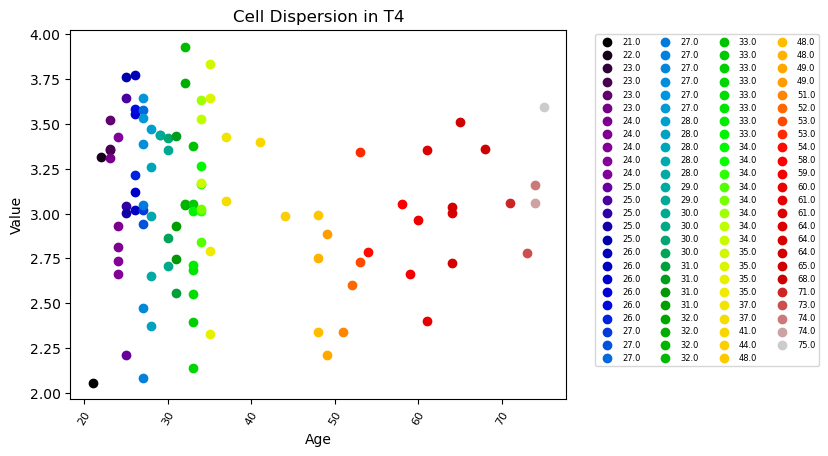

In [21]:
scatter_plot(mean_T4, "Cell Dispersion in T4", "T4")

斜率 :  
-0.003108 x + 3.169


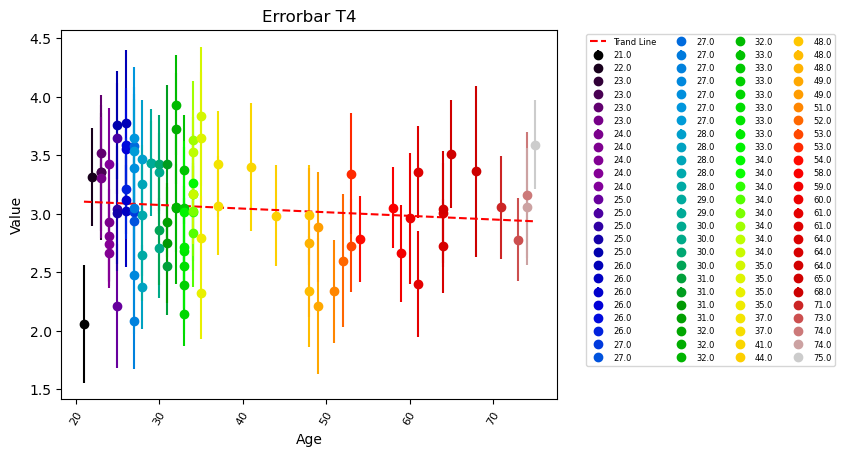

In [22]:
errorbar(mean_T4, std_T4, "Errorbar T4", "T4")

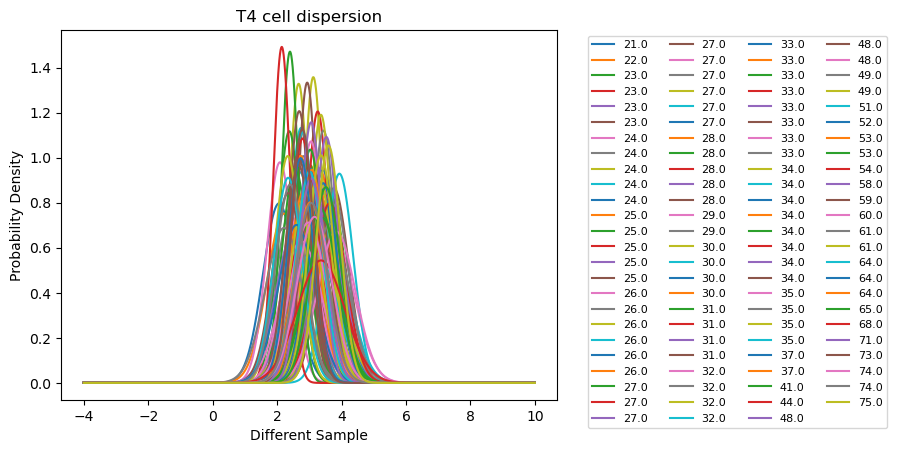

In [23]:
distribution(mean_T4, std_T4, age, "T4")

# T8 cell dispersion

In [24]:
dispersion_personal_T8, mean_T8, std_T8 = Excute_all(sorted_personal, "T8")

100%|██████████| 99/99 [03:14<00:00,  1.96s/it]


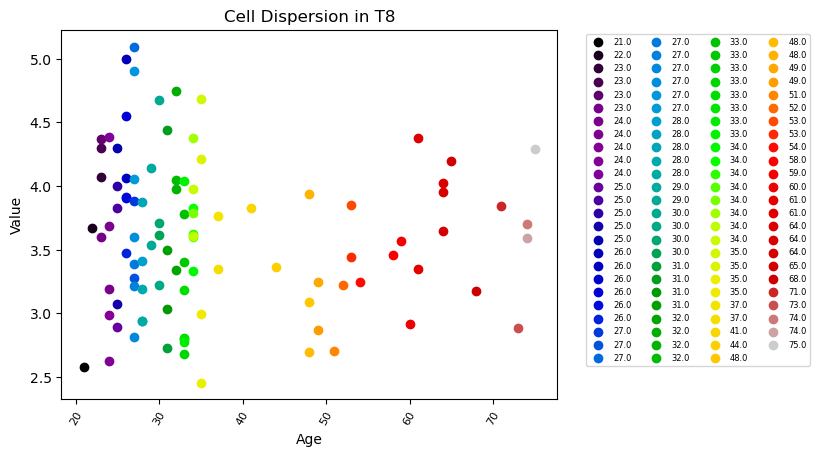

In [25]:
scatter_plot(mean_T8, "Cell Dispersion in T8", "T8")

斜率 :  
-0.002887 x + 3.715


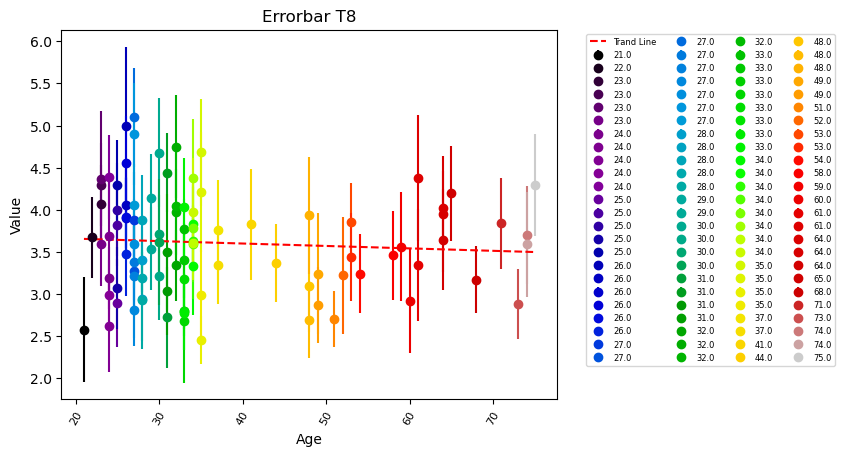

In [26]:
errorbar(mean_T8, std_T8, "Errorbar T8", "T8")

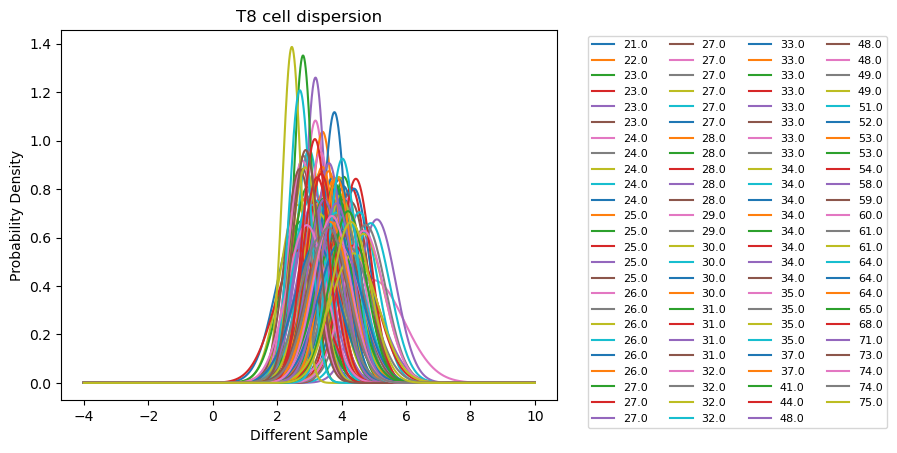

In [27]:
distribution(mean_T8, std_T8, age, "T8")

# B cell dispersion

In [28]:
dispersion_personal_B, mean_B, std_B = Excute_all(sorted_personal, "B")

100%|██████████| 99/99 [02:05<00:00,  1.27s/it]


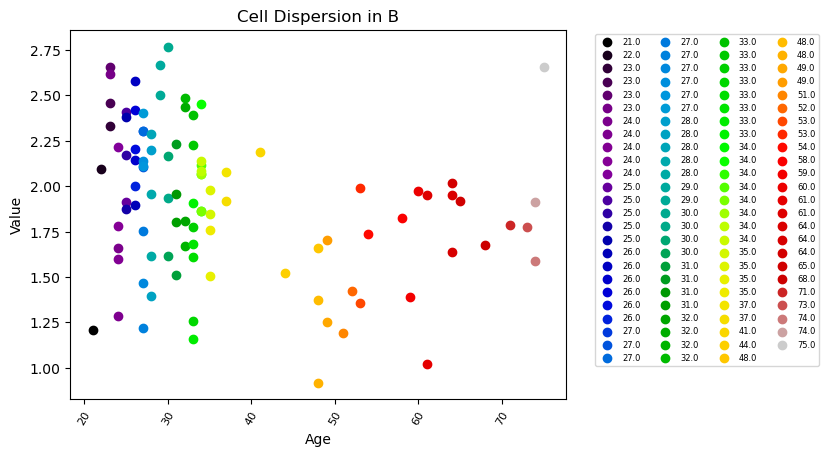

In [29]:
scatter_plot(mean_B, "Cell Dispersion in B", "B")

斜率 :  
-0.00788 x + 2.21


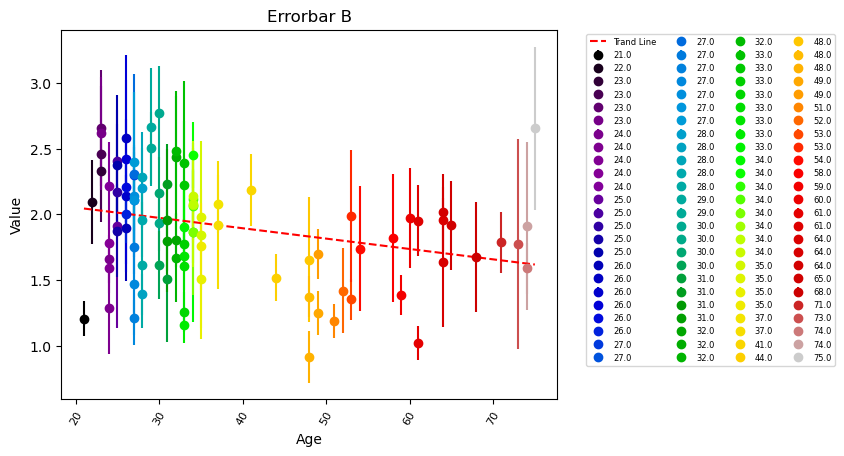

In [30]:
errorbar(mean_B, std_B, "Errorbar B", "B")

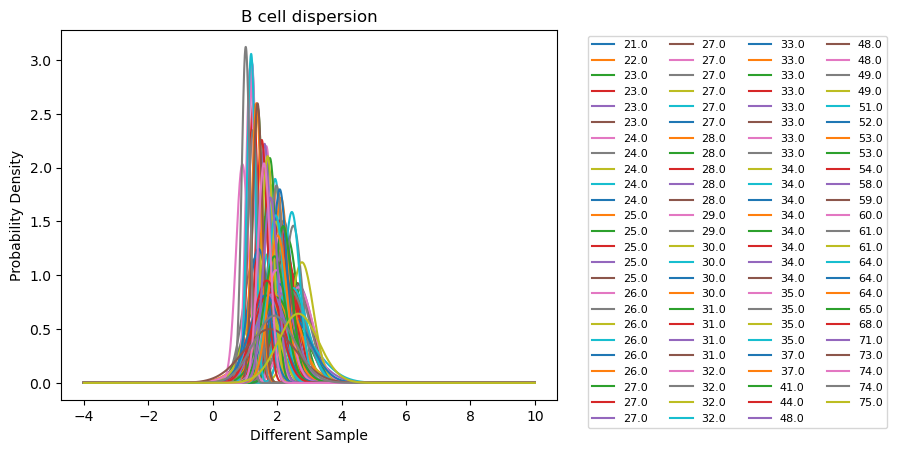

In [31]:
distribution(mean_B, std_B, age, "B")

In [32]:
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'cg_cov_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Mean & Std寫檔

In [41]:
import csv
with open('mean_and_stdev_GSE174188.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    # 寫入列名
    writer.writerow([''] + ['age', 'mean_NK', 'mean_T4', 'mean_T8', 'mean_B', 'mean_cM', 'std_NK', 'std_T4', 'std_T8', 'std_B', 'std_cM'])
    
    # 寫入數據
    for sample, Age, Mean_NK, Mean_T4, Mean_T8, Mean_cM, Mean_B, Std_NK, Std_T4, Std_T8, Std_B, Std_cM in zip(sorted_personal, age, mean_NK, mean_T4, mean_T8, mean_cM, mean_B, std_NK, std_T4, std_T8, std_B, std_cM):
        writer.writerow([sample] + [Age, Mean_NK, Mean_T4, Mean_T8, Mean_B, Mean_cM, Std_NK, Std_T4, Std_T8, Std_B, Std_cM])

In [42]:
# 繪製直方圖
#plt.hist(dispersion_NK, bins=30, density=True)
#plt.xlabel('Dispersion')
#plt.ylabel('Probability Density')